# Day3課題 - 鈴木雅彦

## 前置き

11/3(土)のDay3講義中に以下のことが決まった。
- 全員で精度を競いつつ、有効な手法を共有する
- 対象の課題は「Car Fuel Consumption」（回帰問題）で統一する
- 先頭10%をテストデータ、残りの90%を学習用データとする

鈴木はDay1,2課題にて「Kickstarter Projects」（分類問題）に取り組んでいたので１から取り組む。

## 結論
- 現時点で最も精度が高いのはRandomForestRegressorのMAE 0.467425
- 以下は未実施
 - [] 説明変数の標準化
 - [] 説明変数の無相関化
 - [] 各モデルのハイパーパラメタの調整
 - [] 特徴選択による変数の削減
 - [] Kerasを使ったDNNモデルでの予測

## Pythonライブラリを読み込む

In [1]:
# データハンドリング
import numpy as np
import pandas as pd

# 可視化
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 前処理
from sklearn.preprocessing import MinMaxScaler # 正規化
from sklearn.preprocessing import StandardScaler # 標準化

# 汎化誤差検証
#from sklearn.model_selection import train_test_split # ホールドアウト法
#from sklearn.model_selection import KFold # 交差検証法

# 回帰問題
from sklearn.linear_model import LinearRegression # 線形回帰
from sklearn.metrics import mean_absolute_error, mean_squared_error # 性能評価
from sklearn.tree import DecisionTreeRegressor # 決定木
from sklearn.ensemble import RandomForestRegressor # ランダムフォレスト
from sklearn.ensemble import AdaBoostRegressor # アダブースト
from sklearn.ensemble import BaggingRegressor # バギング

In [2]:
# データフレームの情報を表示する関数
# この後も何度か使うので関数として定義しておく
def show_dataframe_info(df):
    display(df.shape)
    display(df.index)
    display(pd.DataFrame({
        'name': df.columns,
        'dtypes': df.dtypes,
        'count': df.count(),
        'null': df.isnull().sum()
    }))
    display(df.head())

## データファイルを取得する

1. [Car Fuel Consumption | Kaggle](https://www.kaggle.com/anderas/car-consume)ページを開く

1. [DownloadAll](https://www.kaggle.com/anderas/car-consume/downloads/car-consume.zip/5) リンクからZIPをダウンロードする

1. ZIPを解答する
```
$ cd ~/Downloads
$ unzip car-consume.zip
```

1. データファイルを作業フォルダに配置する
```
$ cp ~/Downloads/measurements.csv ~/Desktop/ml_tokyo_8/git/data/
```

1. gitにpushしておく
```
$ git add data/measurements.csv 
$ git commit -m 'https://www.kaggle.com/anderas/car-consume'
$ git push
```

各列について
詳細は[Kaggle](https://www.kaggle.com/anderas/car-consume/home)の「Content」章を参照

| 型 | 名称 | 説明 |
| :-: | :-- | :-- |
| # | distance        | 走行距離(km) |
| # | consume       | 消費量(L/100km) |
| # | speed            | 平均速度(km/h) |
| # | temp_inside   | 車内温度(°C) |
| # | temp_outside | 車外温度(°C) |
| A | specials         | 特記事項 エアコン、雨など |
| A | gas_type       | ガソリン種別 (SP98:ハイオク, E10:バイオエタノール10％混合) |
| # | AC                | エアコン(1:ON, 2:OFF) |
| # | rain               | 雨が降っていたかどうか(1:YES, 2:NO) |
| # | sun               | 晴れていて車が暖かかったかどうか(1:YES, 2:NO) |
| # | refill liters      | 給油価格 (参考情報〜SP98:1.38€/L, E10:エタノール10％混合1.46€/L) |
| A | refill gas        | 給油ガソリン種別(SP98, E10) |

In [3]:
# ファイルの確認
!pwd
!wc data/measurements.csv

/Users/suzukimasahiko/Desktop/ml_tokyo_8/git
     389     410   14561 data/measurements.csv


先頭10%をテストデータ、残りの90%を学習用データとする。
データの前処理、有効な特徴量の選定、相関などの傾向分析は学習データのみで行う必要がある。
また欠損値の補完、無相関化などの下準備(preparetion)は学習データから得られた値(平均や共分散行列)のみを利用して実行する必要がある。

In [4]:
# 1行目のヘッダを除き、先頭10%をテストデータ、末尾90%を学習データとする
filepath = 'data/measurements.csv'
nrows_file = sum(1 for line in open(filepath))
nrows_test = int( (nrows_file - 1) * (10 / 100)) 

# 学習データに対する処理

## ファイルの読み込み

In [5]:
# ヘッダを除く先頭10%を読み飛ばして、末尾90%を学習データとして読み込む
df_train = pd.read_csv(filepath, skiprows=range(1, nrows_test))
show_dataframe_info(df_train)

(351, 12)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,object,351,0
consume,consume,object,351,0
speed,speed,int64,351,0
temp_inside,temp_inside,object,339,12
temp_outside,temp_outside,int64,351,0
specials,specials,object,93,258
gas_type,gas_type,object,351,0
AC,AC,int64,351,0
rain,rain,int64,351,0
sun,sun,int64,351,0


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,"4,9","7,4",26,"21,5",6,NaN,E10,0,0,0,NaN,NaN
1,"11,8","4,8",23,"21,5",9,NaN,E10,0,0,0,NaN,NaN
2,"12,3","6,5",58,"21,5",7,NaN,E10,0,0,0,NaN,NaN
3,"12,4",4,55,"21,5",7,AC rain,E10,1,1,0,NaN,NaN
4,"4,5",5,29,"21,5",7,AC,E10,1,0,0,NaN,NaN


## 各列のデータを扱いやすい形式に加工する
最終的にobject型のデータをすべてfloat型かint型にする

In [6]:
# 1, 0の表記は符号なし8ビット整数型に変換する
def convert_flags(df):
    for column in ['AC', 'rain', 'sun']:
        df[column] = df[column].astype('uint8')
    return df

df_train = convert_flags(df_train)
show_dataframe_info(df_train)

# 今回は引数の参照渡し＋関数内での破壊的処理なのでreturnと=代入は不要だが、
# 記述方法の統一と可読性のためあえてこの書き方をしておく

(351, 12)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,object,351,0
consume,consume,object,351,0
speed,speed,int64,351,0
temp_inside,temp_inside,object,339,12
temp_outside,temp_outside,int64,351,0
specials,specials,object,93,258
gas_type,gas_type,object,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,"4,9","7,4",26,"21,5",6,NaN,E10,0,0,0,NaN,NaN
1,"11,8","4,8",23,"21,5",9,NaN,E10,0,0,0,NaN,NaN
2,"12,3","6,5",58,"21,5",7,NaN,E10,0,0,0,NaN,NaN
3,"12,4",4,55,"21,5",7,AC rain,E10,1,1,0,NaN,NaN
4,"4,5",5,29,"21,5",7,AC,E10,1,0,0,NaN,NaN


In [7]:
# 文字列型に変換 → カンマをドットに置換 → 符号付き64ビット少数型に変換
def convert_floats(df):
    for column in ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'refill liters']:
        df[column] = df[column].apply(lambda x: str(x).replace(',', '.')).astype(float)
    return df

df_train = convert_floats(df_train)
show_dataframe_info(df_train)

(351, 12)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,339,12
temp_outside,temp_outside,float64,351,0
specials,specials,object,93,258
gas_type,gas_type,object,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,4.9,7.4,26.0,21.5,6.0,NaN,E10,0,0,0,NaN,NaN
1,11.8,4.8,23.0,21.5,9.0,NaN,E10,0,0,0,NaN,NaN
2,12.3,6.5,58.0,21.5,7.0,NaN,E10,0,0,0,NaN,NaN
3,12.4,4.0,55.0,21.5,7.0,AC rain,E10,1,1,0,NaN,NaN
4,4.5,5.0,29.0,21.5,7.0,AC,E10,1,0,0,NaN,NaN


In [8]:
# gas_type(ガソリン種別)は質的変数(カテゴリカルデータ)なので、
# gas_type_SP98(ガソリン種別がSP98かどうか(1:YES, 2:NO))で表される量的変数(ダミー変数)に変換する
def convert_gastype(df):
    # 内容を確認する->SP98とE10の2値のみ
    display(df['gas_type'].value_counts())
    # 以下の記述方法だと入力によって結果が不安定になるため、没
    # df = pd.get_dummies(df, columns=['gas_type'], drop_first=True)
    # gas_type列の値がSP98なら1、E10を含むその他の値であれば0をgas_type_SP98列として追加
    df['gas_type_SP98'] = df['gas_type'].apply(lambda x: x == 'SP98').astype('uint8')
    # 作成された値の確認
    display(df['gas_type_SP98'].value_counts())
    # gas_type列は不要になるので削除する
    df = df.drop(columns=['gas_type'])
    return df

df_train = convert_gastype(df_train)
show_dataframe_info(df_train)

SP98    228
E10     123
Name: gas_type, dtype: int64

1    228
0    123
Name: gas_type_SP98, dtype: int64

(351, 12)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,339,12
temp_outside,temp_outside,float64,351,0
specials,specials,object,93,258
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
refill liters,refill liters,float64,12,339


,distance,consume,speed,temp_inside,temp_outside,specials,AC,rain,sun,refill liters,refill gas,gas_type_SP98
0,4.9,7.4,26.0,21.5,6.0,NaN,0,0,0,NaN,NaN,0
1,11.8,4.8,23.0,21.5,9.0,NaN,0,0,0,NaN,NaN,0
2,12.3,6.5,58.0,21.5,7.0,NaN,0,0,0,NaN,NaN,0
3,12.4,4.0,55.0,21.5,7.0,AC rain,1,1,0,NaN,NaN,0
4,4.5,5.0,29.0,21.5,7.0,AC,1,0,0,NaN,NaN,0


In [9]:
# specials(特記事項)列を削除する
def drop_specials(df):
    # 内容を確認する
    display(df['specials'].value_counts())
    # これらはAC(エアコン), gas_type(ガソリン種別), rain(雨), sun(晴れ)でほぼほぼ説明できる
    display(df[df['specials'].notnull()])
    # この列は不要と判断し、削除する
    df = df.drop(columns=['specials'])
    return df

df_train = drop_specials(df_train)
show_dataframe_info(df_train)

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
AC Sun                 1
half rain half sun     1
ac rain                1
AC sun                 1
AC snow                1
Name: specials, dtype: int64

,distance,consume,speed,temp_inside,temp_outside,specials,AC,rain,sun,refill liters,refill gas,gas_type_SP98
3,12.4,4.0,55.0,21.5,7.0,AC rain,1,1,0,NaN,NaN,0
4,4.5,5.0,29.0,21.5,7.0,AC,1,0,0,NaN,NaN,0
13,11.8,5.1,29.0,21.5,5.0,rain,0,1,0,NaN,NaN,1
16,13.1,6.1,46.0,21.5,6.0,rain,0,1,0,NaN,NaN,1
18,153.5,4.9,82.0,21.5,3.0,rain,0,1,0,NaN,NaN,1
22,12.3,5.7,52.0,21.5,8.0,rain,0,1,0,NaN,NaN,1
23,2.9,7.9,18.0,21.5,9.0,AC rain,1,1,0,NaN,NaN,1
32,11.8,4.5,37.0,21.5,4.0,AC,1,0,0,NaN,NaN,1
48,12.3,6.2,58.0,20.0,11.0,rain,0,1,0,NaN,NaN,1
49,13.2,4.3,51.0,20.0,11.0,rain,0,1,0,NaN,NaN,1


(351, 11)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,339,12
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
refill liters,refill liters,float64,12,339
refill gas,refill gas,object,12,339


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,refill gas,gas_type_SP98
0,4.9,7.4,26.0,21.5,6.0,0,0,0,NaN,NaN,0
1,11.8,4.8,23.0,21.5,9.0,0,0,0,NaN,NaN,0
2,12.3,6.5,58.0,21.5,7.0,0,0,0,NaN,NaN,0
3,12.4,4.0,55.0,21.5,7.0,1,1,0,NaN,NaN,0
4,4.5,5.0,29.0,21.5,7.0,1,0,0,NaN,NaN,0


In [10]:
# refill liters(給油価格)列を削除する
def drop_refillliters(df):
    # 一応内容を確認しておく
    display(df[df['refill liters'].notnull()])
    # 欠損値が多く、正しい補完は困難と思われる
    # またドメイン知識により説明変数への影響は無いものと考えられる
    # よってこの列は不要と判断し、削除する
    df = df.drop(columns=['refill liters'])
    return df
    
df_train = drop_refillliters(df_train)
show_dataframe_info(df_train)

# refill gas(給油ガソリン種別)ごとに平均値などを保存しておくと何かの役に立つかも？

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,refill gas,gas_type_SP98
7,5.4,3.3,32.0,21.5,7.0,0,0,0,37.6,SP98,1
45,10.5,3.6,42.0,20.0,10.0,0,0,0,37.7,SP98,1
69,162.7,5.5,75.0,23.0,1.0,0,0,0,45.0,SP98,1
102,16.1,5.4,24.0,21.5,7.0,0,1,0,38.0,E10,0
134,44.4,4.8,38.0,21.5,8.0,0,0,0,38.3,E10,0
154,43.7,4.7,44.0,22.0,9.0,0,1,0,10.0,SP98,1
155,12.1,4.2,43.0,22.0,4.0,0,0,0,39.0,SP98,1
197,19.0,4.5,29.0,22.5,10.0,0,0,0,39.0,E10,0
237,25.7,4.9,50.0,22.0,10.0,0,1,0,41.0,SP98,1
276,11.3,4.3,38.0,22.0,17.0,0,0,0,37.0,SP98,1


(351, 10)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,339,12
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
refill gas,refill gas,object,12,339
gas_type_SP98,gas_type_SP98,uint8,351,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill gas,gas_type_SP98
0,4.9,7.4,26.0,21.5,6.0,0,0,0,NaN,0
1,11.8,4.8,23.0,21.5,9.0,0,0,0,NaN,0
2,12.3,6.5,58.0,21.5,7.0,0,0,0,NaN,0
3,12.4,4.0,55.0,21.5,7.0,1,1,0,NaN,0
4,4.5,5.0,29.0,21.5,7.0,1,0,0,NaN,0


In [11]:
# refill gas(給油ガソリン種別)列を削除する
def drop_refillgas(df):
    # 内容を確認する->値が入っているのは13行のみ
    display(df['refill gas'].value_counts())
    # これらはgas_type_SP98で表現できる
    display(df[df['refill gas'].notnull()])
    # よってこの列は不要と判断し、削除する
    df = df.drop(columns=['refill gas'])
    return df
    
df_train = drop_refillgas(df_train)
show_dataframe_info(df_train)

SP98    8
E10     4
Name: refill gas, dtype: int64

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill gas,gas_type_SP98
7,5.4,3.3,32.0,21.5,7.0,0,0,0,SP98,1
45,10.5,3.6,42.0,20.0,10.0,0,0,0,SP98,1
69,162.7,5.5,75.0,23.0,1.0,0,0,0,SP98,1
102,16.1,5.4,24.0,21.5,7.0,0,1,0,E10,0
134,44.4,4.8,38.0,21.5,8.0,0,0,0,E10,0
154,43.7,4.7,44.0,22.0,9.0,0,1,0,SP98,1
155,12.1,4.2,43.0,22.0,4.0,0,0,0,SP98,1
197,19.0,4.5,29.0,22.5,10.0,0,0,0,E10,0
237,25.7,4.9,50.0,22.0,10.0,0,1,0,SP98,1
276,11.3,4.3,38.0,22.0,17.0,0,0,0,SP98,1


(351, 9)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,339,12
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
gas_type_SP98,gas_type_SP98,uint8,351,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_SP98
0,4.9,7.4,26.0,21.5,6.0,0,0,0,0
1,11.8,4.8,23.0,21.5,9.0,0,0,0,0
2,12.3,6.5,58.0,21.5,7.0,0,0,0,0
3,12.4,4.0,55.0,21.5,7.0,1,1,0,0
4,4.5,5.0,29.0,21.5,7.0,1,0,0,0



## 欠損値を補正する

,temp_outside,temp_inside
temp_outside,1.000000,0.353475
temp_inside,0.353475,1.000000


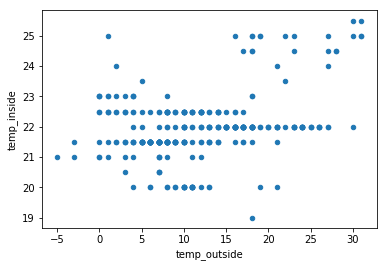

22.0

(351, 9)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,351,0
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
gas_type_SP98,gas_type_SP98,uint8,351,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_SP98
0,4.9,7.4,26.0,21.5,6.0,0,0,0,0
1,11.8,4.8,23.0,21.5,9.0,0,0,0,0
2,12.3,6.5,58.0,21.5,7.0,0,0,0,0
3,12.4,4.0,55.0,21.5,7.0,1,1,0,0
4,4.5,5.0,29.0,21.5,7.0,1,0,0,0


In [12]:
# temp_inside(車内温度)の欠損値をどうするか

# 直感的にはtemp_outside(社外温度)との相関が強そう
display(df_train[['temp_outside', 'temp_inside']].corr())
df_train.plot(x='temp_outside', y='temp_inside', kind='scatter')
plt.show()
# と思いきや、意外とそうでもない
# 線形回帰とかを使って値を求めても精度向上は見込めなそう
# 学習データの平均値を代入することにしよう
# テストデータに対しても同じ処理ができるように値を保持しておく
class temp_inside:
    value = 0

    @classmethod
    def fillna(cls, df):
        df['temp_inside'] = df['temp_inside'].fillna(cls.value)
        return df

# temp_insideの値は0.5刻みで登録されているので、そのフォーマットに順ずる
temp_inside.value = round(df_train['temp_inside'].mean() * 2) / 2
display(temp_inside.value)

df_train = temp_inside.fillna(df_train)
show_dataframe_info(df_train)

## 新たな列を作り出す

In [13]:
# temp_inside(車内温度)とtemp_outside(車外温度)の差を求める
def generate_tempdiff(df):
    df['temp_diff'] = df['temp_inside'] - df['temp_outside']
    return df

df_train = generate_tempdiff(df_train)
show_dataframe_info(df_train)

(351, 10)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,351,0
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
gas_type_SP98,gas_type_SP98,uint8,351,0
temp_diff,temp_diff,float64,351,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_SP98,temp_diff
0,4.9,7.4,26.0,21.5,6.0,0,0,0,0,15.5
1,11.8,4.8,23.0,21.5,9.0,0,0,0,0,12.5
2,12.3,6.5,58.0,21.5,7.0,0,0,0,0,14.5
3,12.4,4.0,55.0,21.5,7.0,1,1,0,0,14.5
4,4.5,5.0,29.0,21.5,7.0,1,0,0,0,14.5


In [14]:
# distance(走行距離)とspeed(平均速度)からtime(走行時間)を求める
def generate_time(df):
    df['time'] = df['distance'] / df['speed']
    return df

df_train = generate_time(df_train)
show_dataframe_info(df_train)

(351, 11)

RangeIndex(start=0, stop=351, step=1)

,name,dtypes,count,null
distance,distance,float64,351,0
consume,consume,float64,351,0
speed,speed,float64,351,0
temp_inside,temp_inside,float64,351,0
temp_outside,temp_outside,float64,351,0
AC,AC,uint8,351,0
rain,rain,uint8,351,0
sun,sun,uint8,351,0
gas_type_SP98,gas_type_SP98,uint8,351,0
temp_diff,temp_diff,float64,351,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_SP98,temp_diff,time
0,4.9,7.4,26.0,21.5,6.0,0,0,0,0,15.5,0.188462
1,11.8,4.8,23.0,21.5,9.0,0,0,0,0,12.5,0.513043
2,12.3,6.5,58.0,21.5,7.0,0,0,0,0,14.5,0.212069
3,12.4,4.0,55.0,21.5,7.0,1,1,0,0,14.5,0.225455
4,4.5,5.0,29.0,21.5,7.0,1,0,0,0,14.5,0.155172


## 各列の相関を見てみる

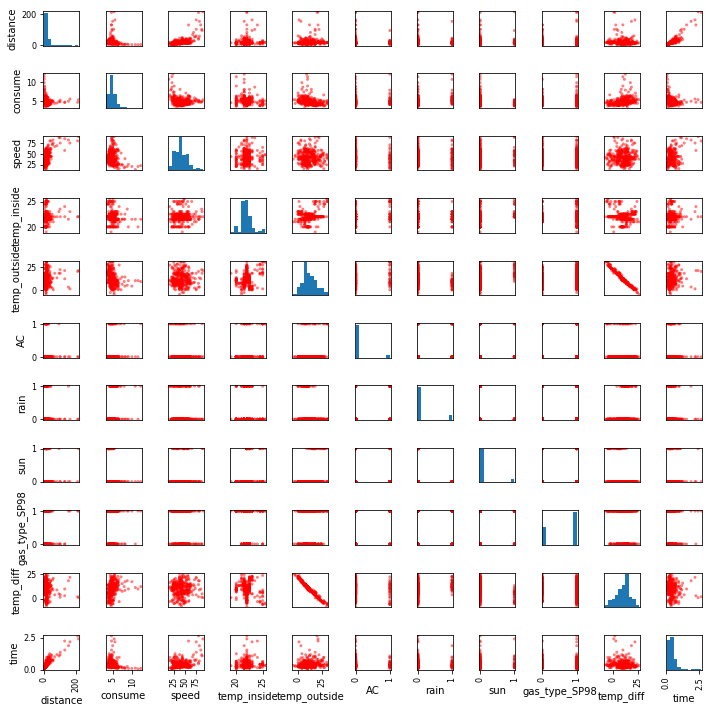

In [15]:
# 散布図
pd.plotting.scatter_matrix(df_train, color='r', figsize=(10, 10))
plt.tight_layout()
plt.show()

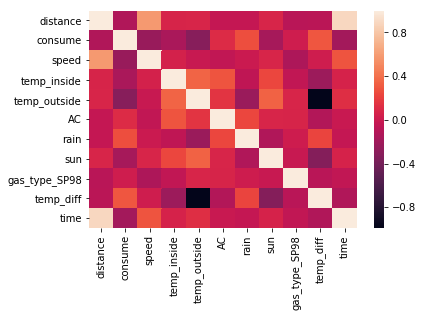

In [16]:
# 相関係数のヒートマップ
sns.heatmap(df_train.corr())
plt.show()

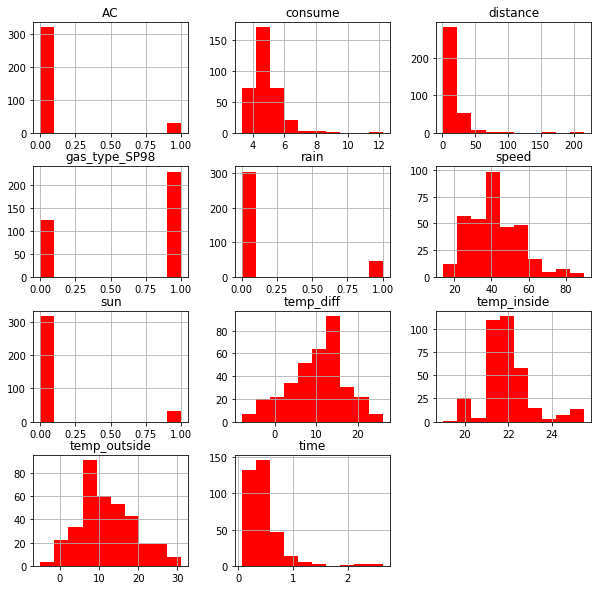

In [17]:
# 度数分布のヒストグラム
df_train.hist(color='r', figsize=(10, 10))
plt.show()

分かったこと
- distance(走行距離)、speed(平均速度)、time(走行時間)は外れ値がある
 - -> 標準化の処理をした方がよさそう
- distance(走行距離)、speed(平均速度)、time(走行時間)は相関がある
- temp_outside(外気温)とtemp_diff(温度差)は逆相関がある
 - -> 無相関化をした方がよさそう
- 説明変数distance(走行距離)とspeed(平均速度)が小さい時に目的変数consume(消費量)のバラつきが大きい
 - -> もしノイズになりそうだったら学習データにおいて値の補正や行の除外をした方がよさそう

## 回帰分析モデルで学習を行う

In [18]:
# 各モデルの結果を比較するためにDataFrameにまとめて登録していく
# (あんまりイケてないからもうちょっと整えたいなぁ)
class evaluate_models:
    results = pd.DataFrame()

    @classmethod
    def evaluate(cls, model_name, data_type, y_correct, y_pred):
        result = {
            'model_name': model_name,
            'data_type': data_type,
            'MSE': mean_squared_error(y_correct, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_correct, y_pred)),
            'MAE': mean_absolute_error(y_correct, y_pred)
        }
        display(result)
        cls.results = cls.results.append(result, ignore_index=True)
        return result


    @classmethod
    def display(cls):
        display(cls.results)
    
    @classmethod
    def scatter(cls, y_correct, y_pred):
        plt.figure(figsize=(8, 8))
        min_y = min(y_correct.min(), y_pred.min()) - 1.0
        max_y = max(y_correct.max(), y_pred.max()) + 1.0
        plt.xlim(min_y, max_y)
        plt.ylim(min_y, max_y)
        plt.xlabel("Porrect")
        plt.ylabel("Predict")
        plt.scatter(y_correct, y_pred)
        plt.show()

In [19]:
# モデルに投入しやすいように学習データを準備
X_train = df_train.drop(columns=['consume']).values
y_train = df_train['consume'].values

/Users/suzukimasahiko/anaconda3/envs/skillupai-ml-tokyo8-20181023/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


{'model_name': 'LinearRegression',
 'data_type': 'Training',
 'MSE': 0.7478355318798389,
 'RMSE': 0.8647748446155443,
 'MAE': 0.5976966375747863}

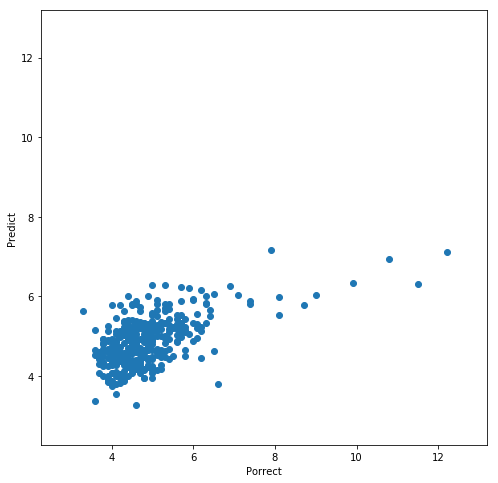

In [20]:
# 線形回帰
regr_lr = LinearRegression()
regr_lr.fit(X_train, y_train)
y_pred = regr_lr.predict(X_train)
# 結果を評価
evaluate_models.evaluate('LinearRegression', 'Training', y_train, y_pred)
# 正解値と予測値を散布図として可視化する
evaluate_models.scatter(y_train, y_pred)

{'model_name': 'RandomForestRegressor',
 'data_type': 'Training',
 'MSE': 0.07037877965495394,
 'RMSE': 0.26528999162228856,
 'MAE': 0.1648244064577396}

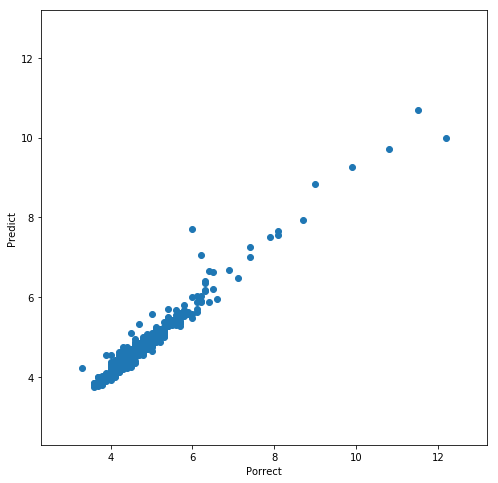

In [21]:
# ランダムフォレスト
regr_rf = RandomForestRegressor(random_state=0, n_estimators=100)
regr_rf.fit(X_train, y_train)
y_pred = regr_rf.predict(X_train)
# 結果を評価
evaluate_models.evaluate('RandomForestRegressor', 'Training', y_train, y_pred)
# 正解値と予測値を散布図として可視化する
evaluate_models.scatter(y_train, y_pred)

{'model_name': 'AdaBoostRegressor',
 'data_type': 'Training',
 'MSE': 0.2776972083236684,
 'RMSE': 0.5269698362559934,
 'MAE': 0.4407381371035013}

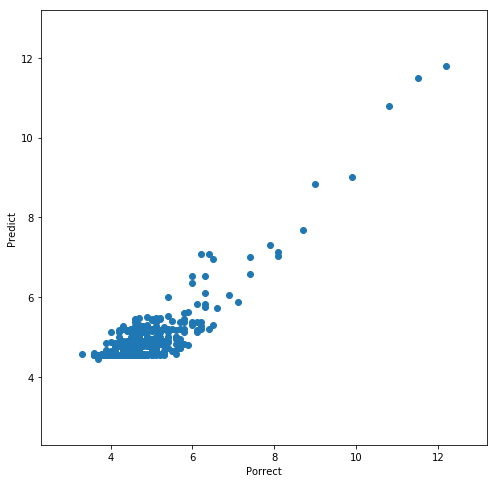

In [22]:
# アダブースト
regr_ab = AdaBoostRegressor()
regr_ab.fit(X_train, y_train)
y_pred = regr_ab.predict(X_train)
# 結果を評価
evaluate_models.evaluate('AdaBoostRegressor', 'Training', y_train, y_pred)
# 正解値と予測値を散布図として可視化する
evaluate_models.scatter(y_train, y_pred)

{'model_name': 'BaggingRegressor',
 'data_type': 'Training',
 'MSE': 0.10043715163026276,
 'RMSE': 0.31691820968550033,
 'MAE': 0.19006647673314342}

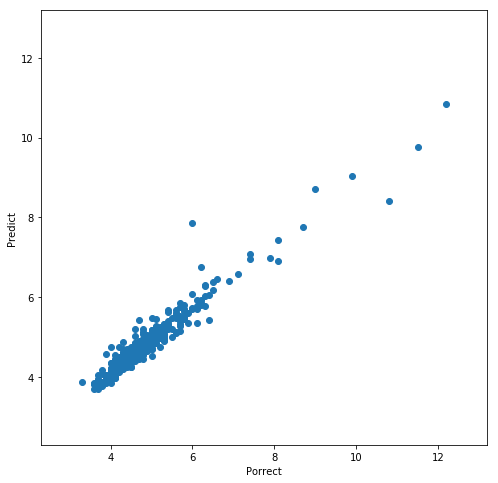

In [23]:
# バギング
regr_bg = BaggingRegressor()
regr_bg.fit(X_train, y_train)
y_pred = regr_bg.predict(X_train)
# 結果を評価
evaluate_models.evaluate('BaggingRegressor', 'Training', y_train, y_pred)
# 正解値と予測値を散布図として可視化する
evaluate_models.scatter(y_train, y_pred)

# テストデータに対する処理

In [24]:
# 先頭10%をテストデータとして読み込む
df_test = pd.read_csv(filepath, nrows=nrows_test)
show_dataframe_info(df_test)

(38, 12)

RangeIndex(start=0, stop=38, step=1)

,name,dtypes,count,null
distance,distance,object,38,0
consume,consume,object,38,0
speed,speed,int64,38,0
temp_inside,temp_inside,object,38,0
temp_outside,temp_outside,int64,38,0
specials,specials,float64,0,38
gas_type,gas_type,object,38,0
AC,AC,int64,38,0
rain,rain,int64,38,0
sun,sun,int64,38,0


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45.0,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [25]:
# 学習データと同等の前処理を施す
df_test = convert_flags(df_test) # 符号なし8ビット整数型に変換
df_test = convert_floats(df_test) # 符号付き64ビット少数型に変換
df_test = convert_gastype(df_test) # gas_typeをダミー変数gas_type_SP98に変換
df_test = drop_specials(df_test) # 列を削除する
df_test = drop_refillliters(df_test) # 列を削除する
df_test = drop_refillgas(df_test) # 列を削除する
df_test = temp_inside.fillna(df_test) #  欠損値を補完する
df_test = generate_tempdiff(df_test) # temp_diffを計算する
df_test = generate_time(df_test) # timeを計算する
show_dataframe_info(df_test)

E10    38
Name: gas_type, dtype: int64

0    38
Name: gas_type_SP98, dtype: int64

Series([], Name: specials, dtype: int64)

,distance,consume,speed,temp_inside,temp_outside,specials,AC,rain,sun,refill liters,refill gas,gas_type_SP98


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,refill gas,gas_type_SP98
0,28.0,5.0,26.0,21.5,12.0,0,0,0,45.0,E10,0


E10    1
Name: refill gas, dtype: int64

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill gas,gas_type_SP98
0,28.0,5.0,26.0,21.5,12.0,0,0,0,E10,0


(38, 11)

RangeIndex(start=0, stop=38, step=1)

,name,dtypes,count,null
distance,distance,float64,38,0
consume,consume,float64,38,0
speed,speed,float64,38,0
temp_inside,temp_inside,float64,38,0
temp_outside,temp_outside,float64,38,0
AC,AC,uint8,38,0
rain,rain,uint8,38,0
sun,sun,uint8,38,0
gas_type_SP98,gas_type_SP98,uint8,38,0
temp_diff,temp_diff,float64,38,0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,gas_type_SP98,temp_diff,time
0,28.0,5.0,26.0,21.5,12.0,0,0,0,0,9.5,1.076923
1,12.0,4.2,30.0,21.5,13.0,0,0,0,0,8.5,0.400000
2,11.2,5.5,38.0,21.5,15.0,0,0,0,0,6.5,0.294737
3,12.9,3.9,36.0,21.5,14.0,0,0,0,0,7.5,0.358333
4,18.5,4.5,46.0,21.5,15.0,0,0,0,0,6.5,0.402174


In [26]:
# モデルに投入しやすいように学習データを準備
X_test = df_test.drop(columns=['consume']).values
y_test = df_test['consume'].values

{'model_name': 'LinearRegression',
 'data_type': 'Generalization',
 'MSE': 0.6052907187102514,
 'RMSE': 0.7780043179251973,
 'MAE': 0.6654299183442901}

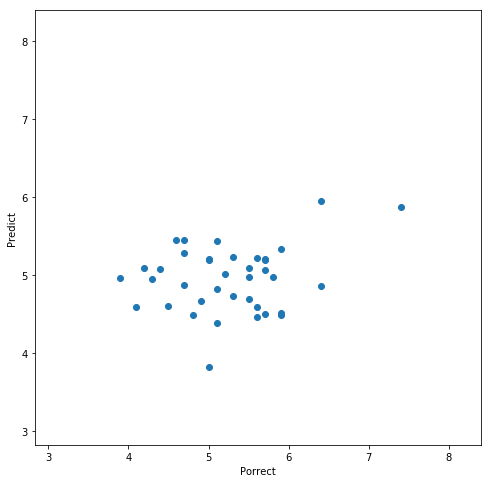

In [27]:
# 線形回帰
y_pred = regr_lr.predict(X_test)
evaluate_models.evaluate('LinearRegression', 'Generalization', y_test, y_pred)
evaluate_models.scatter(y_test, y_pred)

{'model_name': 'RandomForestRegressor',
 'data_type': 'Generalization',
 'MSE': 0.3674133384502928,
 'RMSE': 0.6061463011932786,
 'MAE': 0.46742543859649155}

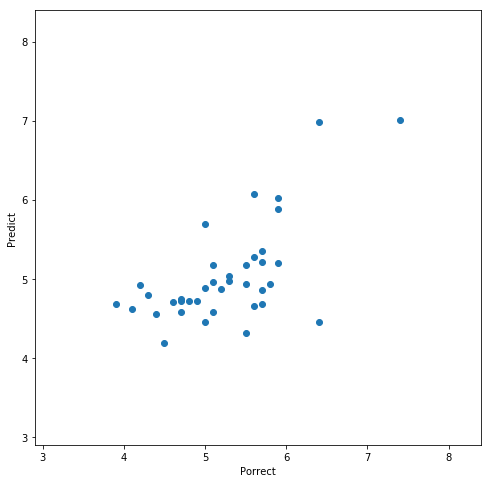

In [28]:
# ランダムフォレスト
y_pred = regr_rf.predict(X_test)
evaluate_models.evaluate('RandomForestRegressor', 'Generalization', y_test, y_pred)
evaluate_models.scatter(y_test, y_pred)

{'model_name': 'AdaBoostRegressor',
 'data_type': 'Generalization',
 'MSE': 0.33614702331530133,
 'RMSE': 0.5797818756353991,
 'MAE': 0.4867857734447966}

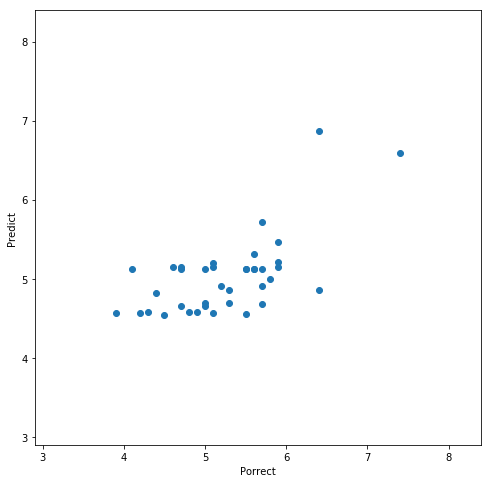

In [29]:
# アダブースト
y_pred = regr_ab.predict(X_test)
evaluate_models.evaluate('AdaBoostRegressor', 'Generalization', y_test, y_pred)
evaluate_models.scatter(y_test, y_pred)

{'model_name': 'BaggingRegressor',
 'data_type': 'Generalization',
 'MSE': 0.41642697368421056,
 'RMSE': 0.6453115322727547,
 'MAE': 0.5238157894736841}

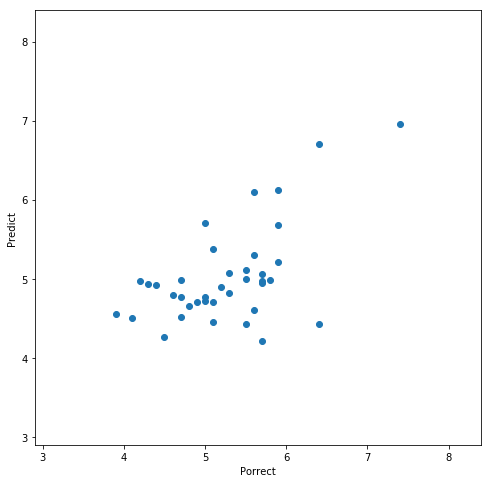

In [30]:
# バギング
y_pred = regr_bg.predict(X_test)
evaluate_models.evaluate('BaggingRegressor', 'Generalization', y_test, y_pred)
evaluate_models.scatter(y_test, y_pred)

## 結果を評価

In [31]:
# 結果をまとめて表示
evaluate_models.display()

,MAE,MSE,RMSE,data_type,model_name
0,0.597697,0.747836,0.864775,Training,LinearRegression
1,0.164824,0.070379,0.265290,Training,RandomForestRegressor
2,0.440738,0.277697,0.526970,Training,AdaBoostRegressor
3,0.190066,0.100437,0.316918,Training,BaggingRegressor
4,0.665430,0.605291,0.778004,Generalization,LinearRegression
5,0.467425,0.367413,0.606146,Generalization,RandomForestRegressor
6,0.486786,0.336147,0.579782,Generalization,AdaBoostRegressor
7,0.523816,0.416427,0.645312,Generalization,BaggingRegressor
